## Supplemental Analysis of SNe-heated Gas Particles 
`-- Leo Lonzarich, 27 September 2021 // [Updated 28-10-21] --`

<i>Supplementing work of Akins H. in 'Justice_League_Code/Analysis/RamPressure/RamPressure.ipynb'</i>


### Table of Contents
- [SN-assisted ram pressure stripping](#rampressure)
    - [Expulsion Probability](#expulsionram)
- [Computing Exit Angles](#exitangle)
    - [Expelled, Ejected SN-Heated Gas](#ejectedheated)
    - [Screening for Distance](#distance)
    - [Screening for Temperature](#temp)


### General Comments on the Contents of this Noteboook  (In no Particular Order)
- Repeated pids that turn up in the data sets below (e.g. 'ejected,' 'expelled,') should mean that the same particle has been accreted and reejected more than once --- hence its reoccurance in the set.


- While each root data set is defined where used, definitions are included here for convenience:
    - *Ejected*: All gas partiles that have been removed from their respective satellite galaxy's disk and into the halo.
    - *Expelled*: All gas particles (either within the disk or halo of their respective satellite galaxy) that have been removed beyond the virial radius of their satellite; that is, all gas that has been completely removed from its respective satellite.


In [22]:
import numpy as np
import pylab
import pynbody
import pynbody.plot.sph as sph
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# importing custom analysis package developed by Akins H.
# from analysis import *

from analysis import * 
#from importlib.machinery import SourceFileLoader
#analysis = SourceFileLoader('analysis', '/home/lonzaric/astro_research/Justice_League_Code/Analysis\
#/RamPressure/analysis

In [23]:
path = '/home/lonzaric/astro_research/ahdata/ram_pressure.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

# listing dwarf galaxies of simulations that are viable for study (gaseous, satellite, etc).
print(len(keys), 'Available Keys:', *keys)

19 Available Keys: h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


In [3]:
data_all = read_all_ram_pressure()

1 Returning (ejected, cooled, expelled, accreted) for h148-13...
2 Returning (ejected, cooled, expelled, accreted) for h148-28...
3 Returning (ejected, cooled, expelled, accreted) for h148-37...
4 Returning (ejected, cooled, expelled, accreted) for h148-45...
5 Returning (ejected, cooled, expelled, accreted) for h148-68...
6 Returning (ejected, cooled, expelled, accreted) for h148-80...
7 Returning (ejected, cooled, expelled, accreted) for h148-283...
8 Returning (ejected, cooled, expelled, accreted) for h148-278...
9 Returning (ejected, cooled, expelled, accreted) for h148-329...
10 Returning (ejected, cooled, expelled, accreted) for h229-20...
11 Returning (ejected, cooled, expelled, accreted) for h229-22...
12 Returning (ejected, cooled, expelled, accreted) for h229-23...
13 Returning (ejected, cooled, expelled, accreted) for h229-27...
14 Returning (ejected, cooled, expelled, accreted) for h229-55...
15 Returning (ejected, cooled, expelled, accreted) for h242-24...
16 Returning (ej

## From RamPressure @Akins: <a class="anchor" id="rampressure"></a>
_______________
_______________

### Probability of Expulsion by Ram Pressure for SNe-heated Gas <a class="anchor" id="expulsionram"></a>

Note that the pressure ratio used here is defined to be ram pressure per restoring pressure, or, $\mathcal{P} \equiv P_{\rm ram}/P_{\rm rest}$. 

In [4]:
ratios_sne, N_e_sne, N_p_sne, E_prob_sne = np.array([]),np.array([]),np.array([]),np.array([])

for key in np.unique(data_all.key):
    # SNe-affected, currently or in last {t_thresh} Gyr
    t_thresh = 0.5 

    d = data_all[data_all.key==key]
    expelled = pd.read_hdf(f'/home/lonzaric/astro_research/ahdata/expelled_particles.hdf5', key=key)
    expelled = expelled[expelled.coolontime > expelled.time - t_thresh]
    particles = read_tracked_particles(key[:4],int(key[5:]))
    particles = particles[(particles.in_sat)&(particles.coolontime > particles.time - t_thresh)]

    expelled_grp = expelled.groupby(['time']).pid.count().reset_index()
    expelled_grp = expelled_grp.rename(columns={'pid':'N_e'})
    particles_grp = particles.groupby(['time']).pid.count().reset_index()
    particles_grp = particles_grp.rename(columns={'pid':'N_p'})

    d = pd.merge(d.sort_values('t'), expelled_grp.sort_values('time'), left_on='t', right_on='time', how='left')
    d = pd.merge(d.sort_values('t'), particles_grp.sort_values('time'), left_on='t', right_on='time', how='left')

    times = np.unique(d.time)
    ratios1 = np.array(d.ratio)
    N_e1 = np.array(d.N_e)[1:]
    N_p1 = np.array(d.N_p)[:-1]
    E_prob1 = N_e1/N_p1
    ratios1 = ratios1[1:]

    ratios_sne = np.append(ratios_sne,ratios1)
    N_e_sne = np.append(N_e_sne, N_e1)
    N_p_sne = np.append(N_p_sne, N_p1)
    E_prob_sne = np.append(E_prob_sne, E_prob1)

In [5]:
cond_sne = ~np.isnan(E_prob_sne) & ~np.isinf(E_prob_sne)
ratios_sne = ratios_sne[cond_sne]
N_e_sne = N_e_sne[cond_sne]
N_p_sne = N_p_sne[cond_sne]
E_prob_sne = E_prob_sne[cond_sne]

bins = np.append(np.arange(-4,2,1),2.2)
bc = 0.5*(bins[1:] + bins[:-1])
E_prob_median_sne, E_prob_weighted_sne, E_prob_weighted_log_sne, std_sne = np.array([]),np.array([]),\
    np.array([]),np.array([])

for left_edge, right_edge in zip(bins[:-1],bins[1:]):
    cond = (np.log10(ratios_sne) >= left_edge) & (np.log10(ratios_sne) < right_edge)
    E_prob_weighted_sne = np.append(E_prob_weighted_sne,np.average(E_prob_sne[cond], weights=N_p_sne[cond]))
    E_prob_weighted_log_sne = np.append(E_prob_weighted_log_sne,np.average(E_prob_sne[cond], weights=\
        np.log10(N_p_sne)[cond]))
    E_prob_median_sne = np.append(E_prob_median_sne,np.median(E_prob_sne[cond]))
    std_sne = np.append(std_sne, np.std(E_prob_sne[cond]))

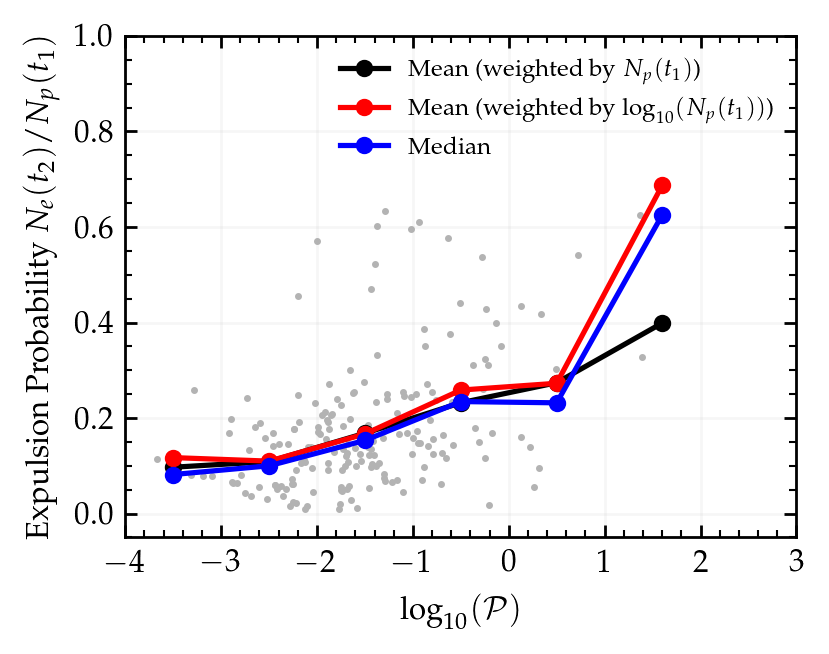

In [6]:
fig, ax = plt.subplots(1,1,dpi=250, figsize=(3.2,2.5), constrained_layout=True)

ax.scatter(np.log10(ratios_sne), E_prob_sne, c='0.7', s=1)
ax.plot(bc, E_prob_weighted_sne, 'ko-', ms=4, label=r'Mean (weighted by $N_p(t_1)$)')
ax.plot(bc, E_prob_weighted_log_sne, 'ro-', ms=4, label=r'Mean (weighted by $\log_{10}(N_p(t_1))$)')
ax.plot(bc, E_prob_median_sne, 'bo-', ms=4, label='Median')

ax.legend(frameon=False, fontsize=7)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'Expulsion Probability $N_{e}(t_2)/N_{p}(t_1)$')
ax.set_xlim(-4, 3)
ax.set_ylim(-0.05, 1)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)
plt.show()

What do the units of the vertical mean? why do we have so few points for greater $\mathcal{P}$?

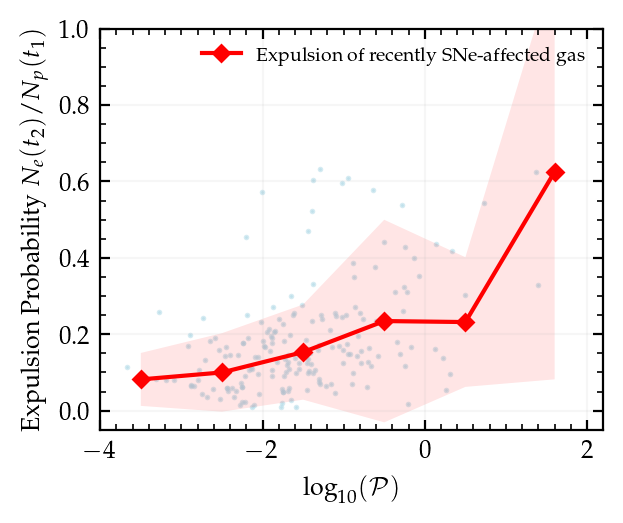

In [7]:
 fig, ax = plt.subplots(1,1,dpi=200, figsize=(3,2.5), sharex=True)

ax.scatter(np.log10(ratios_sne), E_prob_sne, c='lightblue', s=1, alpha=0.5)
ax.fill_between(bc, E_prob_median_sne-std_sne, E_prob_median_sne+std_sne, color='r', ec=None, alpha=0.1)
ax.plot(bc, E_prob_median_sne, 'rD-', ms=4, label=r'Expulsion of recently SNe-affected gas')

ax.legend(frameon=False, fontsize=7)
ax.set_xlabel(r'$\log_{10}(\mathcal{P})$')
ax.set_ylabel(r'Expulsion Probability $N_{e}(t_2)/N_{p}(t_1)$')
ax.set_xlim(-4, 2.2)
ax.set_ylim(-0.05, 1)
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

plt.show()

## From ExitAngle: <a class="anchor" id="exitangle"></a>

____
____

### Examining Exit Angle for Fraction of Expelled & Ejected Heated Gas . <a class="anchor" id="ejectedheated"></a>

In the proceeding, we will make the following distinctions:
- 'Expelled' gas refers to those gas particles that have been removed from the halo disk;
- 'Ejected' gas then refers to the gas particles entirely removed from the satellite;


In [8]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
> Returning (ejected, cooled, expelled, accreted) for all available satellites <


In [9]:
# constructing bins for 
N = 20
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

In [10]:
ejected['weight'] = ejected['mass'] / ejected['mass'].sum()
expelled['weight'] = expelled['mass'] / expelled['mass'].sum()

In [25]:
cond = ejected.coolontime > ejected.time
hot_ejected = ejected[cond]

cond = expelled.coolontime > expelled.time
hot_expelled = expelled[cond]

hot_ejected[['coolontime', 'time']];
hot_expelled[['coolontime', 'time']];

# displaying data for ejected gas, with expelled gas below.
display(hot_ejected[['coolontime', 'time']], hot_expelled[['coolontime', 'time']])

,coolontime,time
196,7.067249,7.039793
268,8.208670,8.198053
299,6.910682,6.905111
299,9.512551,9.490994
309,8.206920,8.198053
...,...,...
4036,7.467925,7.443837
4136,8.748708,8.736778
4164,7.776008,7.767072
4226,7.794526,7.767072


,coolontime,time
131,12.173343,12.150951
168,10.770135,10.767100
252,6.928359,6.905111
277,10.373126,10.352954
309,6.930042,6.905111
...,...,...
3832,7.446983,7.443837
3971,7.794526,7.767072
4123,7.771502,7.767072
4335,7.779375,7.767072


In [27]:
hot_expelled

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,state1,angle,key
131,12.150951,11100527,0.166110,7.213274e+05,19375.947033,12.173343,0.484826,0.008223,0.110528,-0.288046,...,20.529471,False,False,False,False,False,True,sat_disk,132.074365,h148_13
168,10.767100,11568512,0.001280,3.209922e+05,27516.386876,10.770135,3.049596,0.056689,1.480436,2.664205,...,20.143633,False,False,False,False,False,True,sat_halo,35.917638,h148_13
252,6.905111,12793384,0.085164,1.222081e+06,31665.645124,6.928359,0.656143,0.014659,0.163661,0.620284,...,17.825822,False,False,False,False,False,True,sat_disk,120.198725,h148_13
277,10.352954,12794927,0.811883,4.846995e+05,30634.527073,10.373126,0.491615,0.009339,-0.168405,-0.276818,...,19.590469,False,False,False,False,False,True,sat_disk,166.315932,h148_13
309,6.905111,12806958,0.569273,7.571898e+05,31965.985927,6.930042,0.551568,0.012323,-0.376448,0.403002,...,17.825822,False,False,False,False,False,True,sat_disk,132.156794,h148_13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,7.443837,6613409,0.060065,5.107336e+05,27108.266851,7.446983,0.535340,0.019666,-0.043322,0.480116,...,12.407557,False,False,False,False,False,True,sat_halo,73.313802,h329_33
3971,7.767072,6615883,2.320934,6.455797e+05,26724.874151,7.794526,0.133418,0.004713,-0.106013,-0.061565,...,12.023541,False,False,False,False,False,True,sat_disk,67.907242,h329_33
4123,7.767072,6626944,0.061864,2.095657e+05,18690.085854,7.771502,0.994592,0.035137,-0.849875,-0.018678,...,12.023541,False,False,False,False,False,True,sat_disk,51.721102,h329_33
4335,7.767072,6627703,0.013900,3.482225e+05,27251.026654,7.779375,1.171662,0.041392,-0.760433,-0.261090,...,12.023541,False,False,False,False,False,True,sat_disk,119.640462,h329_33


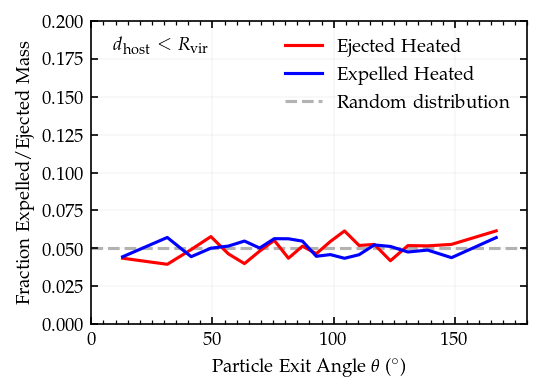

In [12]:
# setting up condition arguments to limit the gas particles we select to those within the virial radius of the satellite; 
# any gas outside of this range we would not classify as belonging to the satellite, and is, thereby, irrelivant to our
# study.
sat_pos = np.array([np.array(hot_ejected.sat_Xc), np.array(hot_ejected.sat_Yc), np.array(hot_ejected.sat_Zc)]).T
host_pos = np.array([np.array(hot_ejected.host_Xc), np.array(hot_ejected.host_Yc), np.array(hot_ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(hot_ejected.hostRvir)


sat_pos = np.array([np.array(hot_expelled.sat_Xc), np.array(hot_expelled.sat_Yc), np.array(hot_expelled.sat_Zc)]).T
host_pos = np.array([np.array(hot_expelled.host_Xc), np.array(hot_expelled.host_Yc), np.array(hot_expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(hot_expelled.hostRvir)


def weight(x, cond=':'):
    # computes weights for each particle; reducing clutter.
    # 'cond' = optional conditions, 'x' = array of attributes.
    return x[cond]/np.sum(x[cond])

    
# plotting.
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.

# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
cond = pos_mag1 < 1
y1, bins = np.histogram(hot_ejected.angle[cond], bins=bins, weights=weight(hot_ejected.mass, cond))
ax.plot(bincenters, y1, label='Ejected Heated', c='r')

cond = pos_mag2 < 1
y2, bins = np.histogram(hot_expelled.angle[cond], bins=bins, weights=weight(hot_expelled.mass, cond))
ax.plot(bincenters, y2, label='Expelled Heated', c='b')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='Random distribution')

ax.legend(frameon=False)

# labels, axis scaling, etc.
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Fraction Expelled/Ejected Mass')
ax.set_xlim(0,180)
ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.1, zorder=-1000)
ax.annotate(r'$d_{\rm host} < R_{\rm vir}$', (0.05, 0.95), xycoords='axes fraction', va='top')

# plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()

It would appear from the plot above that SNe-heated gas favors no particular exit angle, and is instead ejected/expelled nearly equally across a range of angles.

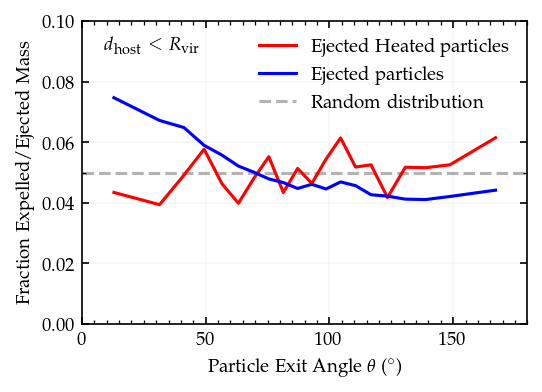

In [13]:
# setting up condition arguments to limit the gas particles we select to those within the virial radius of the satellite; 
# any gas outside of this range we would not classify as belonging to the satellite, and is, thereby, irrelivant to our
# study.
sat_pos = np.array([np.array(hot_ejected.sat_Xc), np.array(hot_ejected.sat_Yc), np.array(hot_ejected.sat_Zc)]).T
host_pos = np.array([np.array(hot_ejected.host_Xc), np.array(hot_ejected.host_Yc), np.array(hot_ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(hot_ejected.hostRvir)


sat_pos = np.array([np.array(hot_expelled.sat_Xc), np.array(hot_expelled.sat_Yc), np.array(hot_expelled.sat_Zc)]).T
host_pos = np.array([np.array(hot_expelled.host_Xc), np.array(hot_expelled.host_Yc), np.array(hot_expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(hot_expelled.hostRvir)


sat_pos = np.array([np.array(ejected.sat_Xc), np.array(ejected.sat_Yc), np.array(ejected.sat_Zc)]).T
host_pos = np.array([np.array(ejected.host_Xc), np.array(ejected.host_Yc), np.array(ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(ejected.hostRvir)


def weight(x, cond=':'):
    # computes weights for each particle; reducing clutter.
    # 'cond' = optional conditions, 'x' = array of attributes.
    return x[cond]/np.sum(x[cond])

    
# plotting.
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.

# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
cond = pos_mag1 < 1
y1, bins = np.histogram(hot_ejected.angle[cond], bins=bins, weights=weight(hot_ejected.mass, cond))
ax.plot(bincenters, y1, label='Ejected Heated particles', c='r')

# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
cond = pos_mag2 < 1
y1, bins = np.histogram(ejected.angle[cond], bins=bins, weights=weight(ejected.mass, cond))
ax.plot(bincenters, y1, label='Ejected particles', c='b')


'''
cond = pos_mag2 < 1
y2, bins = np.histogram(hot_expelled.angle[cond], bins=bins, weights=weight(hot_expelled.mass, cond))
ax.plot(bincenters, y2, label='Expelled particles', c='b')
'''

# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='Random distribution')

ax.legend(frameon=False)

# labels, axis scaling, etc.
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Fraction Expelled/Ejected Mass')
ax.set_xlim(0,180)
ax.set_ylim(0,0.1)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.1, zorder=-1000)
ax.annotate(r'$d_{\rm host} < R_{\rm vir}$', (0.05, 0.95), xycoords='axes fraction', va='top')

# plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()

In [14]:
ejected.keys() # check reference frame these were made in. 

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'angle', 'key', 'weight'],
      dtype='object')

It would appear from the plot above that there SN-heated gas favors no particular exit angle, and is instead ejected/expelled nearly equally across a range of angles.


### Screening Exit Angles by Distance <a class="anchor" id="distance">

In [15]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
> Returning (ejected, cooled, expelled, accreted) for all available satellites <


In [16]:
N = 20 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

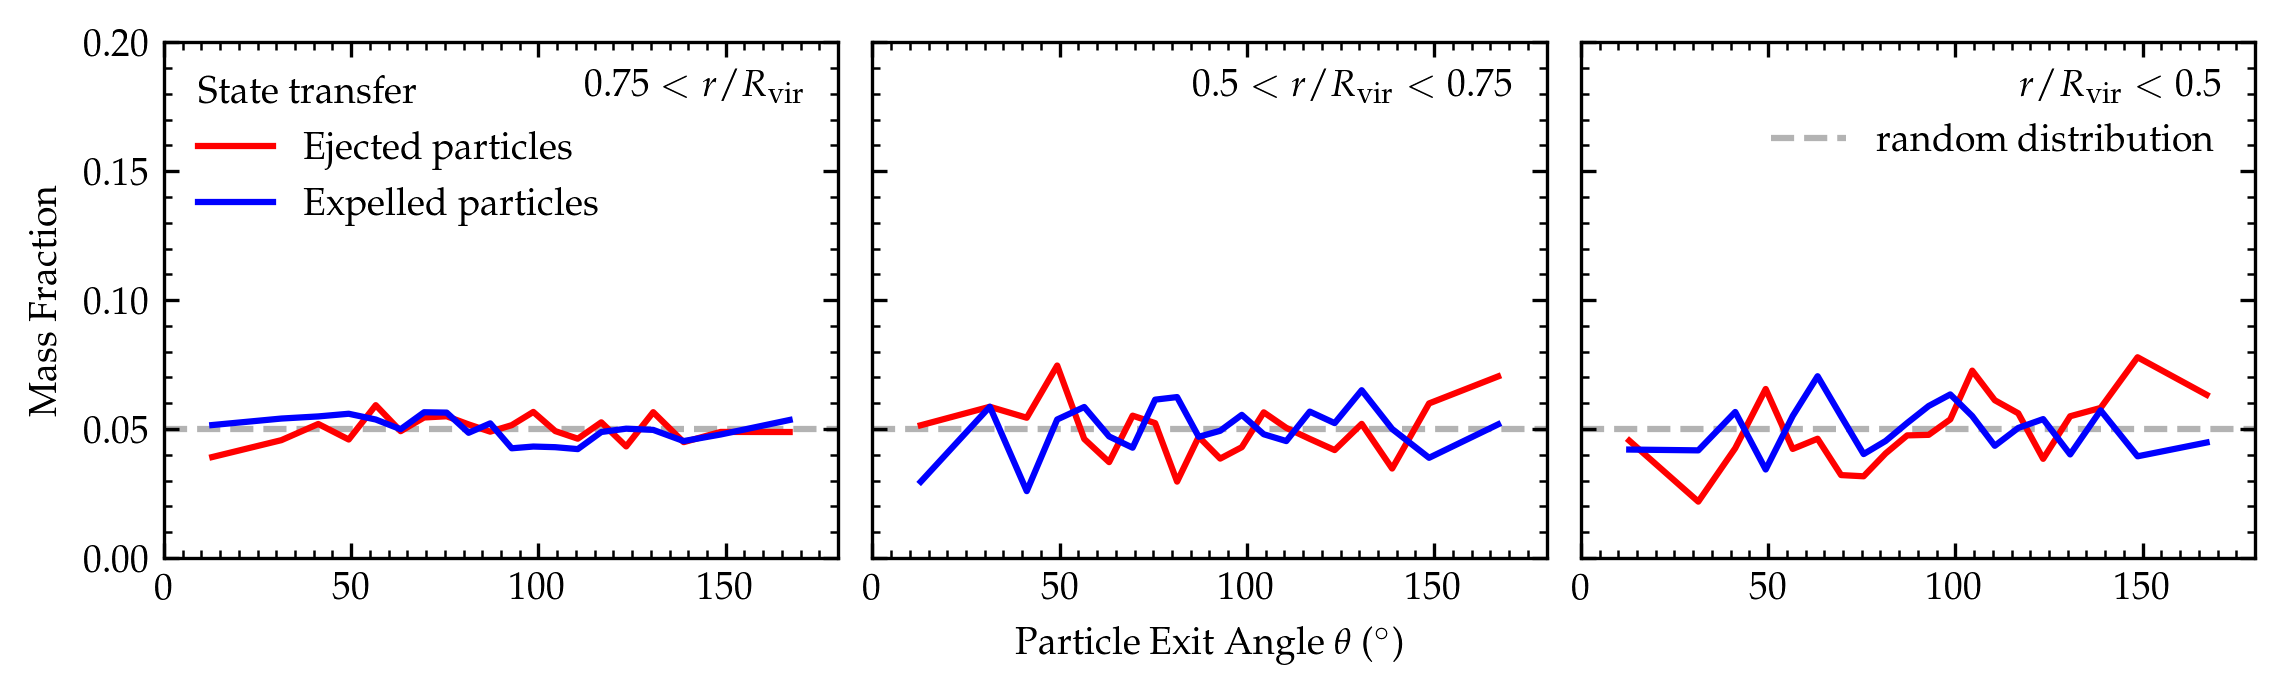

In [17]:
sat_pos = np.array([np.array(hot_ejected.sat_Xc), np.array(hot_ejected.sat_Yc), np.array(hot_ejected.sat_Zc)]).T
host_pos = np.array([np.array(hot_ejected.host_Xc), np.array(hot_ejected.host_Yc), np.array(hot_ejected.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(hot_ejected.hostRvir)

sat_pos = np.array([np.array(hot_expelled.sat_Xc), np.array(hot_expelled.sat_Yc), np.array(hot_expelled.sat_Zc)]).T
host_pos = np.array([np.array(hot_expelled.host_Xc), np.array(hot_expelled.host_Yc), np.array(hot_expelled.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(hot_expelled.hostRvir)

fig,ax = plt.subplots(1,3, dpi=300, figsize=(7.5,2.2), sharey=True)



# left plot will be for r > 0.75
ax[0].annotate(r'$0.75 < r/R_{\rm vir}$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 >= 0.75
y1, bins = np.histogram(hot_ejected.angle[cond], bins=bins, weights=weight(hot_ejected.mass,cond))
l1 = r'Ejected particles'
ax[0].plot(bincenters, y1, label=l1, color='r')

cond = pos_mag2 > 0.75
y2, bins = np.histogram(hot_expelled.angle[cond], bins=bins, weights=weight(hot_expelled.mass,cond))
l2 = r'Expelled particles'
ax[0].plot(bincenters, y2, label=l2, color='b')



# middle plot will be for 0.5 < r < 0.75
ax[1].annotate(r'$0.5 < r/R_{\rm vir} < 0.75$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = (pos_mag1 >= 0.5) & (pos_mag1 < 0.75)

y1, bins = np.histogram(hot_ejected.angle[cond], bins=bins, weights=weight(hot_ejected.mass,cond))
ax[1].plot(bincenters, y1, color='r')

cond = (pos_mag2 >= 0.5) & (pos_mag2 < 0.75)
y2, bins = np.histogram(hot_expelled.angle[cond], bins=bins, weights=weight(hot_expelled.mass,cond))
ax[1].plot(bincenters, y2, color='b')



# right plot will be r < 0.5
ax[2].annotate(r'$r/R_{\rm vir} < 0.5$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 < 0.5
y1, bins = np.histogram(hot_ejected.angle[cond], bins=bins, weights=weight(hot_ejected.mass,cond))
ax[2].plot(bincenters, y1, color='r')

cond = pos_mag2 < 0.5
y2, bins = np.histogram(hot_expelled.angle[cond], bins=bins, weights=weight(hot_expelled.mass,cond))
ax[2].plot(bincenters, y2, color='b')



# plot the line that represents a random distribution
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0].legend(title='State transfer', loc='upper left')
leg1._legend_box.align = 'left'
ax[2].legend(loc=(0.26,0.74))

# labels and ticks and such
ax[1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass Fraction')
for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.2)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

# plt.savefig('plots/theta_allsats_byR.pdf')
plt.show()

Note that $r/R_{vir}$ represents the percent distance of the virial radius of the satellite. For example, the leftmost plot gives exit angles of gas particles existing at radial distances greater than $0.75R_{vir}$ from the center of the satellite.

We again see that there are no well-defined patterns in exit angles to be gleaned by looking at different radial ranges. What might be noted, however, is that for the gas particles at radial positions $>0.75R_{vir}$, mass is far more evenly ejected/expelled across the range of exit angles. Below $0.75R_{vir}$, the distribution is much more erratic. 

### Screening Exit Angles by Temperature <a class="anchor" id="temperature">

In [24]:
ejected, cooled, expelled, accreted = read_all_ejected_expelled()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
> Returning (ejected, cooled, expelled, accreted) for all available satellites <


In [19]:
N = 20 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

In [20]:
hot_ejected.temp.describe()

count      3458.000000
mean      44286.093439
std       48050.437921
min        1380.869995
25%       16460.891602
50%       26240.503906
75%       48801.511719
max      398943.750000
Name: temp, dtype: float64

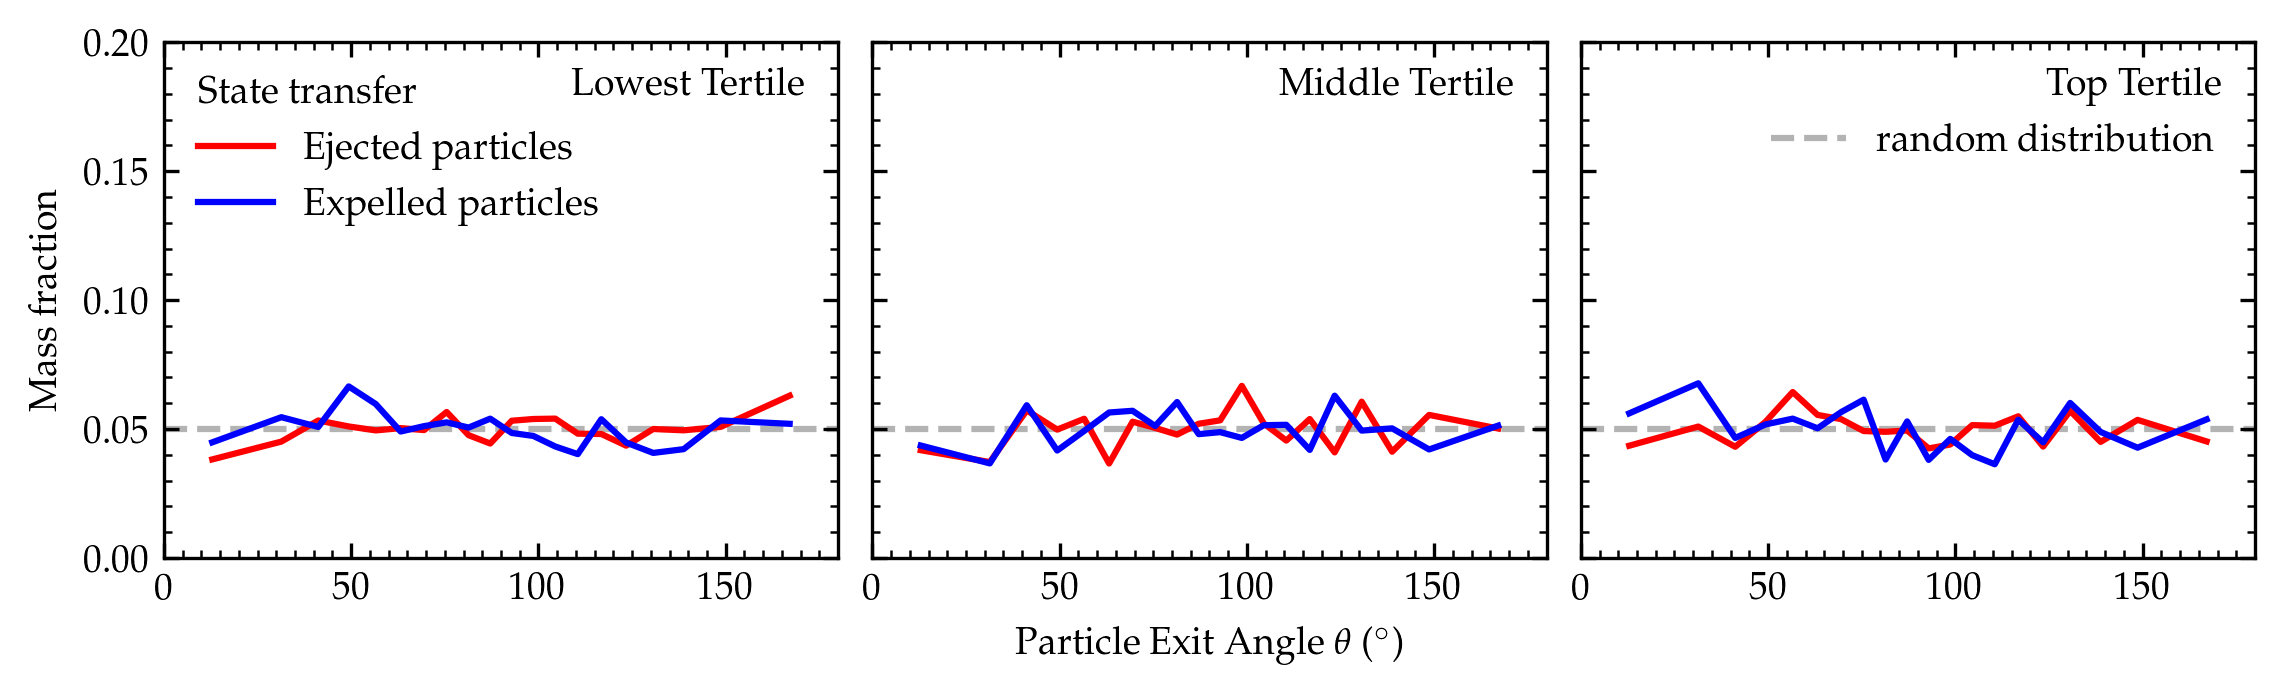

In [21]:
# creating two-entry arrays for temp condition; position '0' corresponds to ejected gas, '1' corresponds to expelled gas.
temps = [hot_ejected.temp, hot_expelled.temp]

cutoffLow = [np.percentile(temps[0], 33), np.percentile(temps[1], 33)]
cutoffMid = [np.percentile(temps[0], 66), np.percentile(temps[1], 66)]

cond1 = [temps[0] < cutoffLow[0], temps[1] < cutoffLow[1]]
cond2 = [(temps[0] >= cutoffLow[0]) & (temps[0] < cutoffMid[0]),(temps[1] >= cutoffLow[1]) & (temps[1] < cutoffMid[1])]
cond3 = [temps[0] >= cutoffMid[0], temps[1] >= cutoffMid[1]]


fig,ax = plt.subplots(1,3, dpi=300, figsize=(7.5,2.2), sharey=True)



# left plot will be for lowest 33% of temps.
ax[0].annotate(r'Lowest Tertile',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')

y1, bins = np.histogram(hot_ejected.angle[cond1[0]], bins=bins, weights=weight(hot_ejected.mass,cond1[0]))
l1 = r'Ejected particles'
ax[0].plot(bincenters, y1, label=l1, color='r')

y2, bins = np.histogram(hot_expelled.angle[cond1[1]], bins=bins, weights=weight(hot_expelled.mass,cond1[1]))
l2 = r'Expelled particles'
ax[0].plot(bincenters, y2, label=l2, color='b')



# middle plot will be for middle 33% of temps
ax[1].annotate(r'Middle Tertile',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')

y1, bins = np.histogram(hot_ejected.angle[cond2[0]], bins=bins, weights=weight(hot_ejected.mass,cond2[0]))
ax[1].plot(bincenters, y1, color='r')

y2, bins = np.histogram(hot_expelled.angle[cond2[1]], bins=bins, weights=weight(hot_expelled.mass,cond2[1]))
ax[1].plot(bincenters, y2, color='b')



# right plot will be for top 33% of temps.
ax[2].annotate(r'Top Tertile',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')

y1, bins = np.histogram(hot_ejected.angle[cond3[0]], bins=bins, weights=weight(hot_ejected.mass,cond3[0]))
ax[2].plot(bincenters, y1, color='r')

y2, bins = np.histogram(hot_expelled.angle[cond3[1]], bins=bins, weights=weight(hot_expelled.mass,cond3[1]))
ax[2].plot(bincenters, y2, color='b')




# plot the line that represents a random distribution
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0].legend(title='State transfer', loc='upper left')
leg1._legend_box.align = 'left'
ax[2].legend(loc=(0.26,0.74))

# labels and ticks and such
ax[1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass fraction')
for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.2)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

# plt.savefig('plots/theta_allsats_byR.pdf')
plt.show()

For this case, we see negligible differentiation when screening for the temperature of the SN-heated gas particles.